# PIC 16A Project: Implementing Supervised Machine Learning Techniques to Predict Antarctic Penguin Species

### By: Chris Conatzer and Zachary Qian

**Due Date: December 11, 2020**

## Group Contribution Statement

Chris and I (Zach) mostly split our work in half. The two of us both did our own initial data cleaning and preprocessing, which included conversion to discrete numerical values for our categorical values. Chris built the bulk of our data visualization and exploratory analysis, providing us with ample figures in this capstone project. Meanwhile, Zach primarily focused on feature selection optimization and modeling; I also provide the analysis in the discussion, with some consultation with Chris (see imputation section). 


# Brief Introduction

With these data, collaborators aimed to implement machine learning techniques, such as logistic regression and decision tree modeling, to predict the species of penguins in Antarctica.

# Exploratory Analysis

For our exploratory anaysis, we first displayed basic statistics as well as some basic visualizations showing the distribution of our data. We also wanted to identify counts between our categorical variables, such as island origin and sex.

### I. Loading data and Relevant dependencies

In [1]:
# ... 
import urllib
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import tree, preprocessing
import numpy as np

In [2]:
#from our discussion activities, we load the data
url = 'https://philchodrow.github.io/PIC16A/content/IO_and_modules/IO/palmer_penguins.csv'
filedata = urllib.request.urlopen(url)
with open('penguins.csv', 'wb') as f:
    f.write(filedata.read())
penguins = pd.read_csv('penguins.csv')

In [3]:
penguins.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,11/11/07,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,11/11/07,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,11/16/07,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
3,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,11/16/07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,11/16/07,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN


### II. Preprocessing

As expected, our raw data has incomplete (or censored) rows that need to be cleaned prior to our machine learning model or even data visualization. We can do this by defining a function that does this for us. We define it as `clean()`.

In [229]:
from sklearn import preprocessing
def clean(df):
    """
    Clean is specifically here to remove NaN values or get rid of nonsensical values in our data.
    For example, we are specifically targeting the one value in Sex that isn't Male or Female and is a "."
    
    We also use preprocessing's LabelEncoder() for the qualitative/categorical variables to convert to numeric.
    Input: dataframe
    Output: dataframe
    """
    df = df.dropna() #rid of NaN rows
    
    df = df[df.Sex != "." ]
    le = preprocessing.LabelEncoder() #change our categorical to discrete numerics
    for i in ["Island","Sex","Species"]: #transform categorical data iteratively, recommended from HW7
        df[i] = le.fit_transform(df[i])
        
    #df["Island"] = le.fit_transform(df["Island"]) #transform categorical data 
    #df["Sex"] = le.fit_transform(df["Sex"]) #WLOG as seen above
    #df["Species"]=le.fit_transform(df["Species"]) #WLOG as seen above
    
    return df 

In [230]:
#get rid of trivial column variables and ridding useless rows
penguins = penguins.drop(['Comments', 'Sample Number', 'Date Egg', 'Clutch Completion', 'Individual ID'
                          ,'studyName','Stage', 'Region'], axis =1) #get rid of trivial columns
penguins = clean(penguins) #clean our penguins dataframe
# keys to each label
Sex    =  {
    0: "FEMALE",
    1: "MALE"
}
Island =  {
    0: "Biscoe",
    1: "Dream",
    2: "Torgersen"
}
Species = {
    0: "Adelie",
    1: "Chinstrap",
    2: "Gentoo"
}


print(penguins.shape)

penguins.head() #quick inspection, doesn't count as a displayed table but we used it for prelim analysis

(324, 9)


,Species,Island,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
1,0,2,39.5,17.4,186.0,3800.0,0,8.94956,-24.69454
2,0,2,40.3,18.0,195.0,3250.0,0,8.36821,-25.33302
4,0,2,36.7,19.3,193.0,3450.0,0,8.76651,-25.32426
5,0,2,39.3,20.6,190.0,3650.0,1,8.66496,-25.29805
6,0,2,38.9,17.8,181.0,3625.0,0,9.18718,-25.21799


### III. Data Visualization and Preliminary Analysis

We first want to provide a Table 1 showing our summary statistics. We define a function for this as well, named `penguin_summary_table()`

In [6]:
def penguin_summary_table(group_cols, value_cols):
    """
    Provides basic summary statistics for our continuous variables.
    
    Requires an input of both a list of columns to group by as well as another list of continuous variables to 
    whose statistics we want to see
    """
    
    return penguins.groupby(group_cols)[value_cols].aggregate([np.mean,np.std])
display(penguin_summary_table(["Species","Sex"], ["Culmen Length (mm)","Culmen Depth (mm)","Body Mass (g)"
                                                  ,"Delta 15 N (o/oo)","Delta 13 C (o/oo)","Flipper Length (mm)"]))    

Culmen Length (mm)           Culmen Depth (mm)            \
                          mean       std              mean       std   
Species Sex                                                            
0       0            37.212676  2.003706         17.619718  0.956126   
        1            40.427941  2.341568         19.057353  1.019265   
1       0            46.573529  3.108669         17.588235  0.781128   
        1            51.069697  1.582222         19.245455  0.771804   
2       0            45.563793  2.051247         14.237931  0.540249   
        1            49.510000  2.728674         15.725000  0.745296   

            Body Mass (g)             Delta 15 N (o/oo)            \
                     mean         std              mean       std   
Species Sex                                                         
0       0     3366.549296  269.554648          8.793275  0.475914   
        1     4053.676471  339.810766          8.928437  0.362755   
1       0     3527.205882  285.333912          9.250962  0.322040   
        1     3938.636364  367.747095          9.464535  0.386763   
2       0     4679.741379  281.578294          8.193405  0.279057   
        1     5488.750000  314.293160          8.303429  0.245151   

            Delta 13 C (o/oo)           Flipper Length (mm)            
                         mean       std                mean       std  
Species Sex                                                            
0       0          -25.794158  0.613175          187.915493  5.620743  
        1          -25.833813  0.562443          192.838235  6.470623  
1       0          -24.565405  0.241078          191.735294  5.754096  
        1          -24.550104  0.202691          199.727273  5.970096  
2       0          -26.197205  0.534377          212.706897  3.897856  
        1          -26.170608  0.554716          221.533333  5.720811

The first and easiest step in visualizing the data is creating a table with the mean and standard deviation of each feature. I chose to group by species and sex to highlight their differences. At first glance the table is horrid mess of values and cells but there is a few things to look at. First is that the females(0) tend to have smaller values across the features measured in (mm). 

The second is that for each feature there is a species that has a mean a few standard deviations different than the others. For instance Adelie(0) have much smaller Culmen Length and Gentoo(2) have smaller Culmen Depths but larger Flippers. Next we are going to take this table and make it more appealing to look at.

#### Scatterplots

""


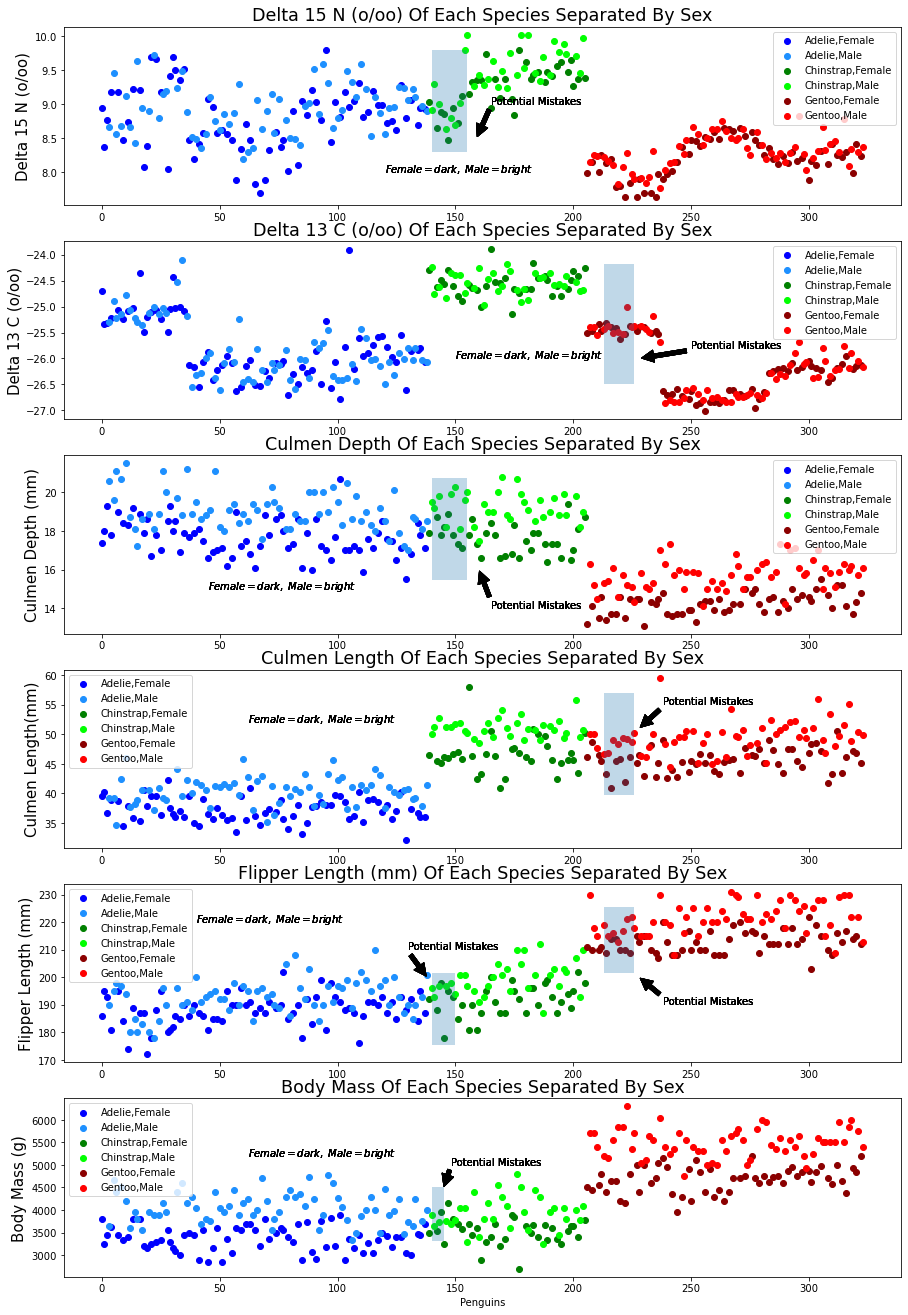

In [241]:
# creates a column labeling each penguin so that
# they can be graphed on the x axis.
p = np.arange(324)
penguins["counter"]= p
# the keys for each label  
Species_Sex = {
    0 : "Adelie,Female",
    5 : "Adelie,Male",
    1 : "Chinstrap,Female",
    6 : "Chinstrap,Male",
    2 : "Gentoo,Female",
    7 : "Gentoo,Male"
}
# the keys for each color
colors3 ={
    0 : "blue",
    5 : "dodgerblue",
    1 : "green",
    6 : "lime",
    2 : "darkred",
    7 : "red"
}
# cant use the the original sex keys
# because 1 + 0 is the same as 0 + 1
# this makes each combination of species and sex unique
sex2= {
    0:0,
    1:5
}

fig, ax = plt.subplots(6, figsize = (15,23))
def Plot_Features(df):
    """
Takes in a dataframe. In this case it is specific to Penguins.
Plots the each feature of penguins separated by species and sex.
Highlights region of potential mistakes.
    """
    # Uses color3 and Species_Sex for unique coloring and labeling
    ax[0].scatter(df["counter"],df["Delta 15 N (o/oo)"], label = Species_Sex[df["Species"].max()+sex2[df["Sex"].max()]],
           color = colors3[df["Species"].max()+sex2[df["Sex"].max()]])
    ax[0].axvspan(140,155,.3,.87, alpha = .05)                                     
    ax[0].text(120, 8, r'$Female= dark,\ Male=bright$')
    ax[0].annotate('Potential Mistakes', xy=(159, 8.5), xytext=(165, 9),
             arrowprops=dict(facecolor='black',shrink = 0.05))
    ax[0].legend()
    ax[0].set(ylabel = "Delta 15 N (o/oo)",title = "Delta 15 N (o/oo) Of Each Species Separated By Sex")
    ax[0].yaxis.label.set_fontsize(15)
    ax[0].title.set_fontsize(17.5)
    
    
    ax[1].scatter(df["counter"],df["Delta 13 C (o/oo)"], label = Species_Sex[df["Species"].max()+sex2[df["Sex"].max()]],
           color = colors3[df["Species"].max()+sex2[df["Sex"].max()]])
    ax[1].axvspan(213,226,.2,.87, alpha = .05)                                     
    ax[1].text(150, -26, r'$Female= dark,\ Male=bright$')
    ax[1].annotate('Potential Mistakes', xy=(228, -26), xytext=(250, -25.8),
             arrowprops=dict(facecolor='black',shrink = 0.05))
    ax[1].legend()
    ax[1].set(ylabel = "Delta 13 C (o/oo)",title = "Delta 13 C (o/oo) Of Each Species Separated By Sex")
    ax[1].yaxis.label.set_fontsize(15)
    ax[1].title.set_fontsize(17.5)
    
    
    ax[2].scatter(df["counter"],df["Culmen Depth (mm)"], label = Species_Sex[df["Species"].max()+sex2[df["Sex"].max()]],
           color = colors3[df["Species"].max()+sex2[df["Sex"].max()]])
    ax[2].axvspan(140,155,.3,.87, alpha = .05)                                     
    ax[2].text(45, 15, r'$Female= dark,\ Male=bright$')
    ax[2].annotate('Potential Mistakes', xy=(160, 16), xytext=(165, 14),
             arrowprops=dict(facecolor='black',shrink = 0.05))
    ax[2].legend()
    ax[2].set(ylabel = "Culmen Depth (mm)",title = "Culmen Depth Of Each Species Separated By Sex")
    ax[2].yaxis.label.set_fontsize(15)
    ax[2].title.set_fontsize(17.5)
    
    ax[3].scatter(df["counter"],df["Culmen Length (mm)"], label = Species_Sex[df["Species"].max()+sex2[df["Sex"].max()]],
           color = colors3[df["Species"].max()+sex2[df["Sex"].max()]])
    ax[3].axvspan(213,226,.3,.87, alpha = .05)                                     
    ax[3].text(62, 52, r'$Female= dark,\ Male=bright$')
    ax[3].annotate('Potential Mistakes', xy=(228, 51), xytext=(238, 55),
             arrowprops=dict(facecolor='black',shrink = 0.05))
    ax[3].legend()
    ax[3].set(ylabel = "Culmen Length(mm)",title = "Culmen Length Of Each Species Separated By Sex")
    ax[3].yaxis.label.set_fontsize(15)
    ax[3].title.set_fontsize(17.5)
    
    ax[4].scatter(df["counter"],df["Flipper Length (mm)"], label = Species_Sex[df["Species"].max()+sex2[df["Sex"].max()]],
           color = colors3[df["Species"].max()+sex2[df["Sex"].max()]])
    ax[4].axvspan(213,226,.5,.87, alpha = .05)
    ax[4].axvspan(140,150,.1,.5, alpha = .05)
    ax[4].text(40, 220, r'$Female= dark,\ Male=bright$')
    ax[4].annotate('Potential Mistakes', xy=(228, 200), xytext=(238, 190),
             arrowprops=dict(facecolor='black',shrink = 0.05))
    ax[4].annotate('Potential Mistakes', xy=(138, 200), xytext=(130, 210),
             arrowprops=dict(facecolor='black',shrink = 0.05))
    ax[4].legend()
    ax[4].set(ylabel = "Flipper Length (mm)",title = "Flipper Length (mm) Of Each Species Separated By Sex")
    ax[4].yaxis.label.set_fontsize(15)
    ax[4].title.set_fontsize(17.5)
    
    ax[5].scatter(df["counter"],df["Body Mass (g)"], label = Species_Sex[df["Species"].max()+sex2[df["Sex"].max()]],
           color = colors3[df["Species"].max()+sex2[df["Sex"].max()]])
    ax[5].axvspan(140,145,.2,.5, alpha = .05)                                     
    ax[5].text(62, 5200, r'$Female= dark,\ Male=bright$')
    ax[5].annotate('Potential Mistakes', xy=(145, 4500), xytext=(148, 5000),
             arrowprops=dict(facecolor='black',shrink = 0.05))
    ax[5].legend()
    ax[5].set(ylabel = "Body Mass (g)", xlabel = "Penguins",title = "Body Mass Of Each Species Separated By Sex")
    ax[5].yaxis.label.set_fontsize(15)
    ax[5].title.set_fontsize(17.5)
    
    
penguins.groupby(["Species","Sex"]).apply(Plot_Features)  

First, we need to interpret each graph. The x-axis is each penguin and the y-axis is a feature. The x-axis is grouped by species in this order(Adelie(blue),Chinstrap(green),Gentoo(red)). **Note that the numbers for penguins do not have significance, and it is purely based on the row the sampled penguin happened to be on.** Our legend show that the females have a darker shade of each color, and males with the lighter color. The highlighted regions show the y-values that two or more species share with another. The potential mistakes annotation means that it would be hard to tell the difference between species if they had feature values in this area, based on observation before model construction.

**Delta 15 N** is the first scatterplot we investigated. Gentoos(2) tend to have smaller values but Adelie(0) have a much wider spread and can share values with Gentoos(2). Chinstrap(1) have the highest values of Delta 15 N on average, but they share values similar to our Adelie(0) samples. Overall Adelie's penguins have a high standard deviation and the amount of shared values between Chinstrap(1) and Gentoo(2), making it another thing to consider for our feature selection.

**Delta 13 C** is the next metric we investigated with our scatterplots. For Adelie(0) there exists a cluster of values between -25.5 and -25 and then the rest of the Adelie(0) penguins have smaller values. Something similiar occurs for Gentoo(2) between -26 and -25.5. We believed that this was a consequence of a confounding variable for not accounting islands each penguin resides on. In future analysis, it would be interesting to perform PCA or TCA to identify these clusters in an unsupervised manner.

The **Culmen Depth** scatterplot shows promise for a possible candidate for our model. Gentoos(2) have clearly smaller values especially if they are female that the other species do not share as much. This starts the highlight the importance of sex as a differentiating factor. For instance take the value 16. We can see that each species share this value which is no good for what we are doing but if we assume that sex is known then this becomes different. The only males with the value 16 are from Gentoo. If we are given female then we will to look at another feature.

**Culmen Length** has a similiar story to Culmen Depth. This is important because the combined information of depth and length is indicative of species. This time Adelie(0) are the ones with smaller values. With 45 being the border between Adelie(0) and the other two species. At this border only the males are from Adelie(0).

**Flipper Length** presents a similar case to Culmen Length and Culmen Depth. In this case Gentoo(2) have the larger flipper lengths while Adelie(0) and Chinstrap(1) share the same length. At the value of about 205 the only females are from Gentoo(2). 

**Lastly, Body mass** does not add much more infomation than Flipper Length. Might be because a bigger flipper correlates to more body mass. Sex however is a bit more distinct with this feature.

#### Histograms

[Text(0, 0.5, 'Number of species in Island')]

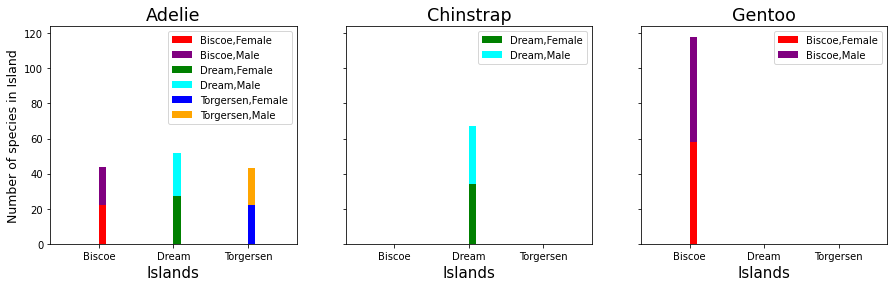

In [261]:
# the two dictionaries combined
# label each stack based on
# species,island,sex
Species_Island_male ={
    5: "Biscoe,Male",
    8: "Dream,Male",
    20: "Torgersen,Male",
    6: "Biscoe,Male",
    9: "Dream,Male",
    21:"Torgersen,Male",
    7: "Biscoe,Male",
    10:"Dream,Male",
    22: "Torgersen,Male"
}
Species_Island_female ={
    5: "Biscoe,Female",
    8: "Dream,Female",
    20: "Torgersen,Female",
    6: "Biscoe,Female",
    9: "Dream,Female",
    21:"Torgersen,Female",
    7: "Biscoe,Female",
    10:"Dream,Female",
    22: "Torgersen,Female"
}
# does the same thing but for color
color_female={
    5:"red",
    8:"green",
    20:"blue",
    6:"green",
    9:"green",
    21:"green",
    7:"red",
    10:"red",
    22:"red"
}
color_male={
    5:"purple",
    8:"cyan",
    20:"orange",
    6:"cyan",
    9:"cyan",
    21:"cyan",
    7:"purple",
    10:"purple",
    22:"purple" 
       
}
# these two dictionaries makes each
# combination of species,island, sex unique
sex2= {
    0:0,
    1:5
}
Island2 ={
    0:5,
    1:8,
    2:20
}
fig, ax = plt.subplots(1,3, figsize = (15,4), sharex = True, sharey= True)
def Histplt_Penguins_Island(df):
    """
Takes in a dataframe. In this case it is specific to Penguins.
Plots number of penguins in each island on separate plots for each species.
Each species is further separated by sex.
    """
    
    colors = [color_female[df["Species"].max()+ Island2[df["Island"].max()]],color_male[df["Species"].max()+ Island2[df["Island"].max()]]]
    labels = [Species_Island_female[df["Species"].max()+ Island2[df["Island"].max()]],Species_Island_male[df["Species"].max()+ Island2[df["Island"].max()]]]
    ax[df["Species"].max()].hist([df["Island"][df["Sex"]==0],df["Island"][df["Sex"]==1]], color = colors,label = labels,
                                 stacked = True)                             
                                        
    ax[df["Species"].max()].set(title = Species[df["Species"].max()],xlabel ="Islands")
    ax[df["Species"].max()].legend()
    ax[df["Species"].max()].set_xticks([0,1,2])
    ax[df["Species"].max()].set_xticklabels(["Biscoe","Dream","Torgersen"])
    ax[df["Species"].max()].title.set_fontsize(17.5)
    ax[df["Species"].max()].yaxis.label.set_fontsize(12.5)
    ax[df["Species"].max()].xaxis.label.set_fontsize(15)
penguins.groupby(["Species","Island"]).apply(Histplt_Penguins_Island)  
ax[0].set(ylabel = "Number of species in Island") 

So far, we had not looked at the Island feature (hence investigating it now). This graph has three stacked histograms, one for each species. The bottom stack represents females, while the top stack represents males. It is color coded according to Island.

This plot shows that the island the penguin is from is a deterministic factor for species. Chinstraps(1) only come from Dream. Gentoos(3) only come from Biscoe. If a penguin is from Torgersen then it must be Adelie(0). Also this reveals that the sex of the penguin does not matter when it comes what island it comes from which seems appropriate.

**Remark:** Also shows that Island does not explain the anomaly on the delta 13 C graph since all Gentoos(2) are from Biscoe.

# Methods: Supervised Machine Learning Implementation (Modeling)

For our machine learning models, we opted to use **logistic regression and decision trees**. Not only were these required by the rubric, but these also work well with our data. 

For logistic regression, not only is it easy to interpret and implement, but it is also efficient in its training and exhibits a natural probabilistic view on predictions between classes/labels. Our data is also pretty simple, and logistic regression performs well for simpler data sets. Moreover, we can avoid overfitting easily using types od regularization methods, as well as tuning our C value.

For decision trees, we can easily visualize our model, as well as require very little preprocessing. Moreover, since its non-parametric, we do not need to assume certain things about the distribution or the shape of our data.

### I. Defining our Labels and Predictor Dataframes

In [17]:
#Create x and y dfs (covariates and labels, respectively)
x = penguins.drop(["Species","counter"],axis = 1)
y = penguins["Species"]


### II. Splitting Data

Since my model had a 100% accuracy with a 75-25% split with Logistic Regression(*see Qian, Homework 7*), I have decided to implement a 70-30% train-test splitting of our penguin data.

In [18]:
from sklearn.model_selection import train_test_split

np.random.seed(1000) #set seed
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.30) #split 70 30 test

### III. Systematic Feature Selection

For my systematic feature selection, I chose my variables based on the score of a 10-fold cross validation score. **Note that these features were also used for the decision tree model as well.**

For the basic framework of the systematic feature selection, I found the set of all subsets of 3 variables and tested performance with our training data. Then, I outputted the scores of each combination of 3 covariates and found the best 1 qualitative and 2 quantitative covariates to choose as my model's very own covariates.

Note that this exhaustive approach assumes that we use **at least 1 feature**. This is used specifically for a supervised machine learning method that has us select features to develop the model. Using 0 features would be trivial *with respect to the project aims*.

In [19]:
#Load dependencies for feature selection and model training
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import neural_network

In [20]:
#Scores for CV found in discussion
def CV_score(cols):
    """
    Seen in class. 
    Trains and evaluates a model via cross-validation on the columns of the data with selected indices
    """
    LR = LogisticRegression(max_iter=10000) #default C = 1

    return cross_val_score(LR, x_train[cols], y_train, cv = 10).mean()  

In [21]:
#First, want to create all the subsets we possibly can have given a size n = 3 because we want 3 total covariates
import itertools
from itertools import combinations, chain

def subsets(arr,n):
    """
    Finds total number of subsets for a given size and existing array using combinations from itertools library
    """
    return list(combinations(arr,n))
cov_subsets = subsets(x_train.columns,3)



In [24]:
x_train.head()

,Island,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
127,2,41.5,18.3,195.0,4300.0,1,8.52566,-26.02450
64,0,36.4,17.1,184.0,2850.0,0,8.62623,-26.11650
103,0,37.8,20.0,190.0,4250.0,1,9.51929,-25.69199
261,0,49.6,16.0,225.0,5700.0,1,8.38324,-26.84272
167,1,50.5,19.6,201.0,4050.0,1,9.80590,-24.72940


In [25]:
# Finding top CV Scores
scores = []
for i in range(0,len(cov_subsets)): #loop through all the combinations
    scores.append(    (cov_subsets[i]   , CV_score(list(cov_subsets[i])))    ) 
    #add to our list of scores based on different column combos

In [27]:
sorted(scores, key=lambda x: x[1],reverse=True)[0:6] #sort by score high to low, show top 10
#list top 10 best performing

[(('Culmen Length (mm)', 'Culmen Depth (mm)', 'Delta 13 C (o/oo)'),
  0.9911067193675889),
 (('Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)'),
  0.9867588932806324),
 (('Culmen Length (mm)', 'Culmen Depth (mm)', 'Delta 15 N (o/oo)'),
  0.9867588932806324),
 (('Culmen Length (mm)', 'Culmen Depth (mm)', 'Body Mass (g)'),
  0.982411067193676),
 (('Culmen Length (mm)', 'Culmen Depth (mm)', 'Sex'), 0.982213438735178),
 (('Culmen Length (mm)', 'Flipper Length (mm)', 'Delta 13 C (o/oo)'),
  0.9778656126482215)]

In [28]:
cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Sex'] #selected covariates

As you can see, we find that the best combination of column values that have 1 categorical and 2 continuous covariates is the combination of **Sex, Culmen Length, and Culmen Depth**.

We will use this for our models.


### IV. Model Construction: Logistic Regression

#### K-Fold Cross-Validation

To optimize our parameters, I tested values from 0.01 to 100, because increasing our C-value makes the model's complexity increase. In doing so, we become prone to being unable to generalize our model's performance.

After performing a 10-fold Cross Validation, we find that our C value that fits best is `C=100`.

**NOTE**: However, to avoid making my model overly complex and to make a simpler, more generalizable model, I chose C = 0.1.

In [263]:
def gridsearch(x,y,k):
    """
    Rudimentary gridsearch I implemented in Homework 7 in a function. Takes values in a list of arrays and 
    tests each value for our C value. 
    """
    #printing out graph and finding best params
    fig, ax = plt.subplots(1, figsize = (10, 10))
    best_score = -1000000 #set abritrary number
    best_depth = 0
    arr = [.001,.01,0.1,1,10,100,1000]
    for i in arr:

        lr = LogisticRegression(C=i, max_iter = 10000)
        cv_score = sklearn.model_selection.cross_val_score(lr,x, y, cv =k).mean()
        #set kfold CV to 10
        if best_score < cv_score:
            best_score = cv_score
            best_depth = i
        ax.scatter(i,cv_score)
        ax.set(xlabel = "C Value", ylabel = "Cross Validation Score")

    ax.set( title = "ML: Finding C Regularization Value: " +  str(best_depth) + " with score: " +  str(best_score))
    ax.title.set_fontsize(17.5)
    ax.yaxis.label.set_fontsize(15)
    ax.xaxis.label.set_fontsize(15)

    return (best_depth, best_score)
    

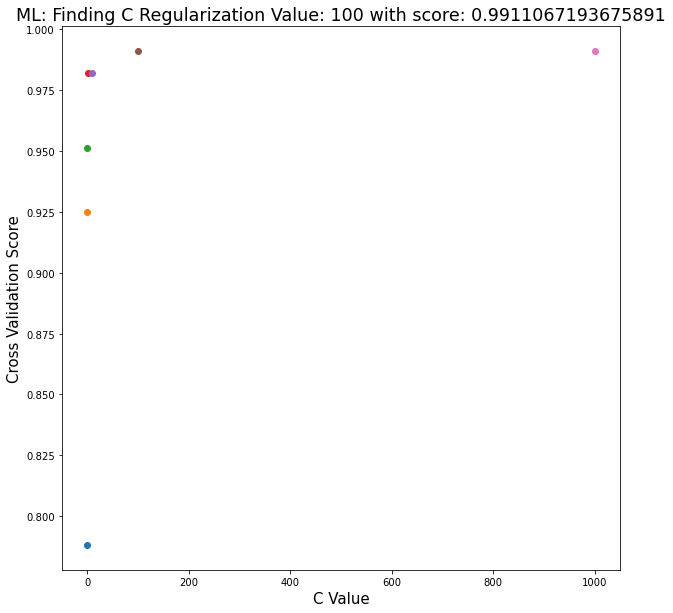

In [264]:
(best_depth, best_score) = gridsearch(x_train[cols],y_train,k=10)

In [41]:
#gridsearch(x_test[cols],y_test,k=10)

### V. Logistic Regression Testing : Handling Overfitness

In testing my model, I found that I had overfit my model with my C parameter. This was intuitive, as setting our `C` parameter to 100 makes the model overly complex and makes it harder to accurately label unseen data, thereby decreasing the ability of our model to correctly model generalized (or even imputed if we wanted to) data.

In [31]:
# OVERFIT CASE: JUST A DEMONSTRATION
ideal_LR = LogisticRegression(C=best_depth, max_iter=10000)
ideal_LR.fit(x_train[cols],y_train)
LR_score = ideal_LR.score(x_test[cols],y_test)
print("Our score with the 3 best parameters and C = 100 is: ", LR_score)
print(ideal_LR.score(x_train[cols],y_train)) #training score
print(LR_score) #test score
#accuracy of test < accuracy of training --> overfit possibility!

Our score with the 3 best parameters and C = 100 is:  0.9897959183673469
1.0
0.9897959183673469


#### Finding best C value for Logistic Regression model

Because C = 100 was overfit in our estimation, we decided to look for C values such that it made our model simpler. If we inspect our graph of Cross Validation scores for C values that are less than 1, we find that C = 0.1 performs best while still simplifying our overall logistic regression model between the values `[0.001,0.01,0.1]`.

Thus, we set our C value to 0.1

In [32]:
best_depth = 0.1
#physically changed my model, after seeing overfit score usng C = 100 (accuracy of test < accuracy of training)
ideal_LR = LogisticRegression(C=best_depth, max_iter=10000)
ideal_LR.fit(x_train[cols],y_train)

LogisticRegression(C=0.1, max_iter=10000)

In [33]:
LR_score = ideal_LR.score(x_test[cols],y_test)
print("Our score with the 3 best parameters and C = 0.1 is: ", LR_score)

Our score with the 3 best parameters and C = 0.1 is:  1.0


In [34]:
print(ideal_LR.score(x_train[cols],y_train)) #training score
print(LR_score) #test score

0.9646017699115044
1.0


### VI. Logistic Regression Error Analysis and Model Evaluation

We can analyze our results through a confusion matrix. We also need a prediction object as well.

We see that we have a total of 0 missed/incorrect labels. Not bad, especially for a 70-30 training-test split!


In [171]:
from sklearn.metrics import confusion_matrix

y_predict = ideal_LR.predict(x_test[cols]) #define our prediction label array as y_predict
confusionMatrix = confusion_matrix(y_test, y_predict) #initialize our confusion matrix

confusionMatrix

array([[46,  0,  0],
       [ 0, 19,  0],
       [ 0,  0, 33]])

In [36]:
mistakes = (x_test[cols])[y_test != y_predict] #find mistakes
mistaken_labels = y_test[y_test != y_predict] #find wrong labels
mistaken_preds = y_predict[y_test != y_predict]

print(mistaken_labels) #the actual labels
print(mistaken_preds) #what we predicted

mistakes.head()

Series([], Name: Species, dtype: int64)
[]


,Culmen Length (mm),Culmen Depth (mm),Sex


### VII. Decision Regions Figures

In [276]:
def plot_decision_regions(df,c):
    """
    Plots the decision regions for logistic regression 
    underneath the data in x and y. 
    C: Classifier
   
    """
  
    # for convenience, give names to the three 
    # columns of the data
    
    # Since this is grouped by Sex we are feeding 
    # the predictions by layers of 0 1 corresponding 
    # to the Sex. Think about this as a 3d model
    # with only 3 values for the z axis but we need one z value
    # for every x, y coordinate(xo, x1) to fill 3 planes.
    # there are 251001 combinations of (xo,x1) coordinates.
    grid = df["Sex"].max()*np.ones(251001)
    
    grid_x = np.linspace(30, 60, 501) #estimtaed using observation
    grid_y = np.linspace(12, 23, 501)
    
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    # extract model predictions, using the 
    # np.c_ attribute to join together the 
    # three parts of the grid. 
    # array.ravel() converts an multidimensional
    # array into a 1d array, and we use array.reshape()
    # to turn the resulting predictions p 
    # back into 2d
    
    p = c.predict(np.c_[xx.ravel(), yy.ravel(),grid])
    p = p.reshape(xx.shape)
    
    # create the plot
    # Each z layer(Sex) is plotted on a separate subplot
    # Each species is a different color
    color = {
        0 : "blue",
        1 : "green",
        2 : "red"
         }
      # used contour plot to visualize the predictions
    ax[df["Sex"].max()].contourf(xx, yy, p,alpha = .07)
    
    
    # use scatter plot to plot the provided the data
    ax[df["Sex"].max()].scatter(df["Culmen Length (mm)"],df["Culmen Depth (mm)"],
                                          color = color[df["Species"].max()], label = Species[df["Species"].max()]) 
    ax[df["Sex"].max()].set(xlabel = "Culmen Length (mm)",title = Sex[df["Sex"].max()],
                                     ylabel = "Culmen Depth (mm)")
    ax[df["Sex"].max()].title.set_fontsize(20)
    ax[df["Sex"].max()].yaxis.label.set_fontsize(20)
    ax[df["Sex"].max()].xaxis.label.set_fontsize(20)
    
    ax[df["Sex"].max()].legend()
#fig,ax =plt.subplots(1,2,figsize =(25,4))

""


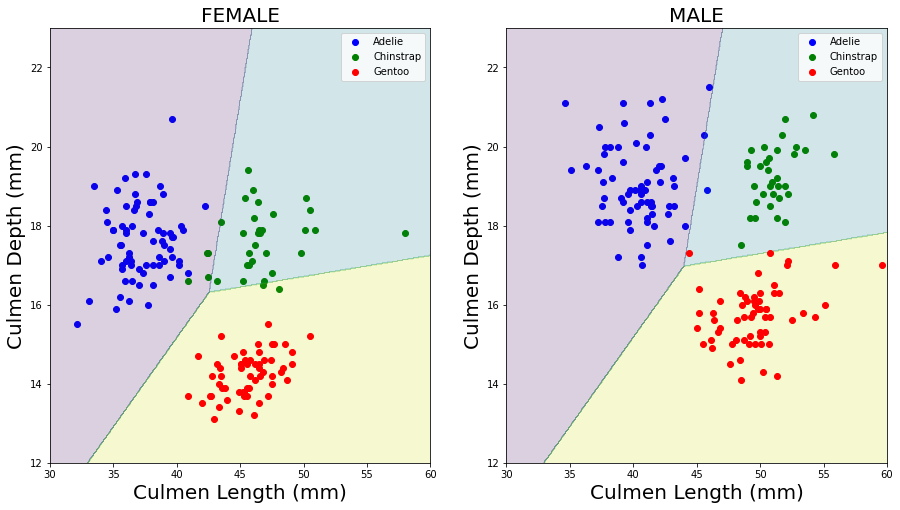

In [277]:
fig,ax =plt.subplots(1,2,figsize =(15,8))
penguins.groupby(["Sex","Species"]).apply(plot_decision_regions,ideal_LR)
     

The shaded area shows what the model's guess on what the species was given a specific point for our grid. The dots represent the **entire** dataset (i.e. all of `penguins`). Additional unseen data would be guessed wrong if a penguin falls within another region of this plot. For instance a Gentoo(2) with culmen depth of 28 and culmen length of 35 mm would be guessed Adelie if such a penguin exists.

If we wanted to look more closely at the decision regions exclusively for our *test* set, we can use the `mlxtend` library to take a closer look.

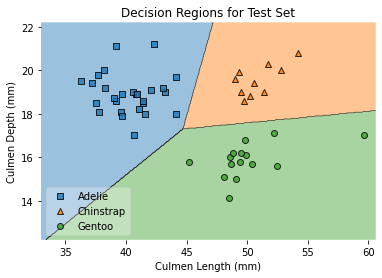

In [192]:
#conda install mlxtend --channel conda-forge (linux execution on command line terminal)
from mlxtend.plotting import plot_decision_regions

ax = plot_decision_regions(np.array(x_test[cols]),np.array(y_test),ideal_LR, 
                     filler_feature_values={2: value},
                      filler_feature_ranges={2: width},
                      legend=0)
plt.xlabel("Culmen Length (mm)")
plt.ylabel("Culmen Depth (mm)")
plt.title("Decision Regions for Test Set")
handles, labels = ax.get_legend_handles_labels() #get the custom handles for custom legend
ax.legend(handles, 
          ['Adelie', 'Chinstrap', 'Gentoo'], 
           framealpha=0.3, scatterpoints=1)

Perfect accuracy!

### VIII. Model Construction: Decision Trees

For decision trees, we will use the same columns to optimize our model. This time, we will test for max_depth optimization.

In [267]:
import string
def tree_gridsearch(x,y,grid):
    """
    Gridsearch used to optimize our tree depth, extremely similar implementation to our gridsearch() function.
    K = 10 in this CV.
    Inputs: x,y, and a grid of values.
    Output: tuple of best depth and best score corresponding to the optimal tree depth.
    """
    fig, ax = plt.subplots(1, figsize = (10, 10))
    best_score = -1000000 #set abritrary number
    best_depth = 0
    for i in grid:
        T = sklearn.tree.DecisionTreeClassifier(max_depth= i )
        cv_score = sklearn.model_selection.cross_val_score(T,x, y, cv = 10).mean() #set our kfold CV score to 10
        if best_score < cv_score:
            best_score = cv_score
            best_depth = i
        ax.scatter(i,cv_score)
        ax.set(xlabel = "Depth Of Tree", ylabel = "Cross Validation Score")

    ax.set( title = "ML: Finding best depth for model is: " +  str(best_depth) + " with a score of: " +  str(best_score))
    ax.title.set_fontsize(17.5)
    ax.yaxis.label.set_fontsize(15)
    ax.xaxis.label.set_fontsize(15)
    return (best_depth, best_score)


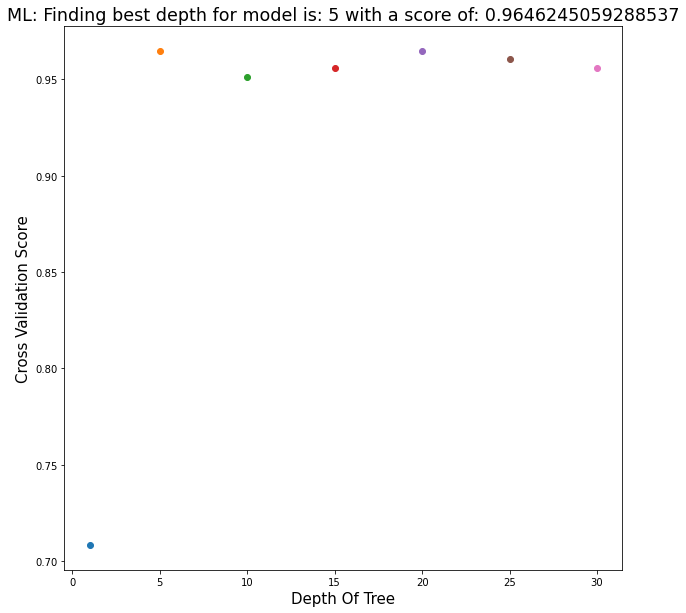

In [268]:
np.random.seed(2000) #set for reproducible results
grid = [1,5,10,15,20,25,30]
(t_depth, t_score) = tree_gridsearch(x_train[cols],y_train,grid) #we finnd that our depth is ideally 5!

### IX. Decision Tree Testing

Using our optimal tree depth, we go test our model with tree depth capped at 5. Pleasantly, we find that both our training set and test only use 5 total branches, while achieving 100% accuracy!

In [226]:
import sklearn
T = sklearn.tree.DecisionTreeClassifier(max_depth= 5)
T.fit(x_train[cols], y_train)

print("Score for Train is: ", T.score(x_train[cols],y_train))
print("Score for Test is: ", T.score(x_test[cols],y_test))

Score for Train is:  1.0
Score for Test is:  1.0


### X. Decision Tree: Error Analysis

We see that again, we have no errors with our depth of 5. Not bad again!

In [196]:
from sklearn.metrics import confusion_matrix

y_predict = T.predict(x_test[cols]) #define our prediction label array as y_predict
confusionMatrix = confusion_matrix(y_test, y_predict) #initialize our confusion matrix

confusionMatrix

array([[46,  0,  0],
       [ 0, 19,  0],
       [ 0,  0, 33]])

In [107]:
mistakes = (x_test[cols])[y_test != y_predict] #find mistakes
mistaken_labels = y_test[y_test != y_predict] #find wrong labels
mistaken_preds = y_predict[y_test != y_predict]

print(mistaken_labels) #the actual labels
print(mistaken_preds) #what we predicted

mistakes.head()

Series([], Name: Species, dtype: int64)
[]


,Culmen Length (mm),Culmen Depth (mm),Sex


### XI. Decision Tree: Decision Regions

""


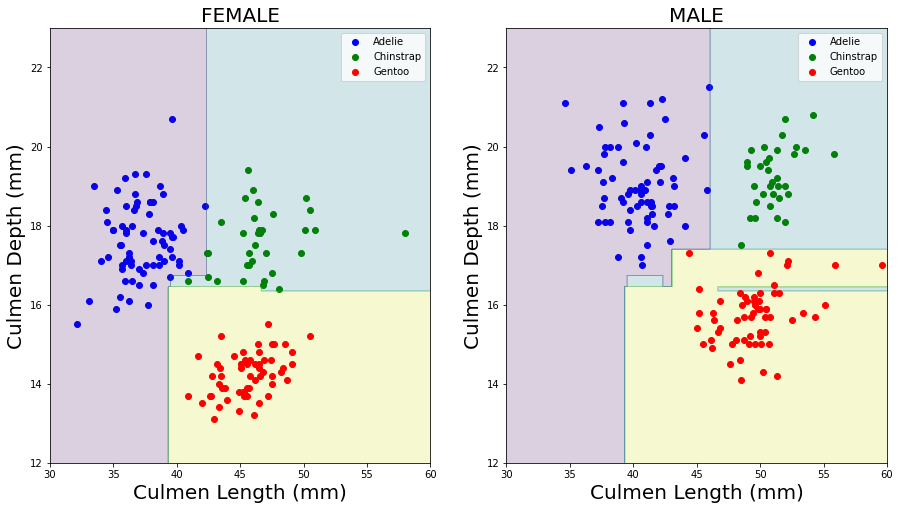

In [278]:
fig,ax =plt.subplots(1,2,figsize =(15,8))

penguins.groupby(["Sex","Species"]).apply(plot_decision_regions,T)

There are two noticable instances of potential overfitting in this model. The Female Chinstrap region pushes itself far into the Adelie region. This is where I suspect there to be mistakes on feature unseeen data as guessing between the two will be difficult. Also on the male side the Chinstrap region is split into two with a small region between Adelie and Gentoo. I suspect unseen data in this region will be mislabled Chinstrap as well.

One way to prevent slight overfitting would be the application of **random forest model** (see discussion) with the tuning of parameters so that we select a confined amount of features per tree, making it more generalizable.

We can also tune our minimum samples per leaf of the tree as well.

We can also look at our decision regions for our test set exclusively here.

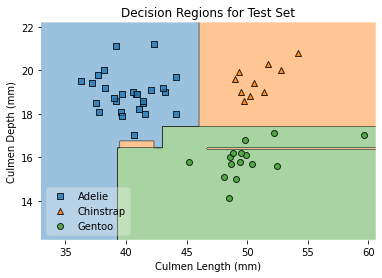

In [202]:

from mlxtend.plotting import plot_decision_regions

value = 1.5 # see width comment
width = 0.75 #filler features requirede for plot_decision_regions when we showcase more than 2 features

ax1 = plot_decision_regions(np.array(x_test[cols]),np.array(y_test),T, 
                     filler_feature_values={2: value},
                      filler_feature_ranges={2: width},
                      legend=0)
plt.xlabel("Culmen Length (mm)")
plt.ylabel("Culmen Depth (mm)")
plt.title("Decision Regions for Test Set")
handles, labels = ax1.get_legend_handles_labels() #get the custom handles for custom legend
ax1.legend(handles, 
          ['Adelie', 'Chinstrap', 'Gentoo'], 
           framealpha=0.3, scatterpoints=1)

The last figure is more of a supplemental figure for the decision tree's actual decision making. Please use it as a supplemental figure as a means for *basic* visualization.

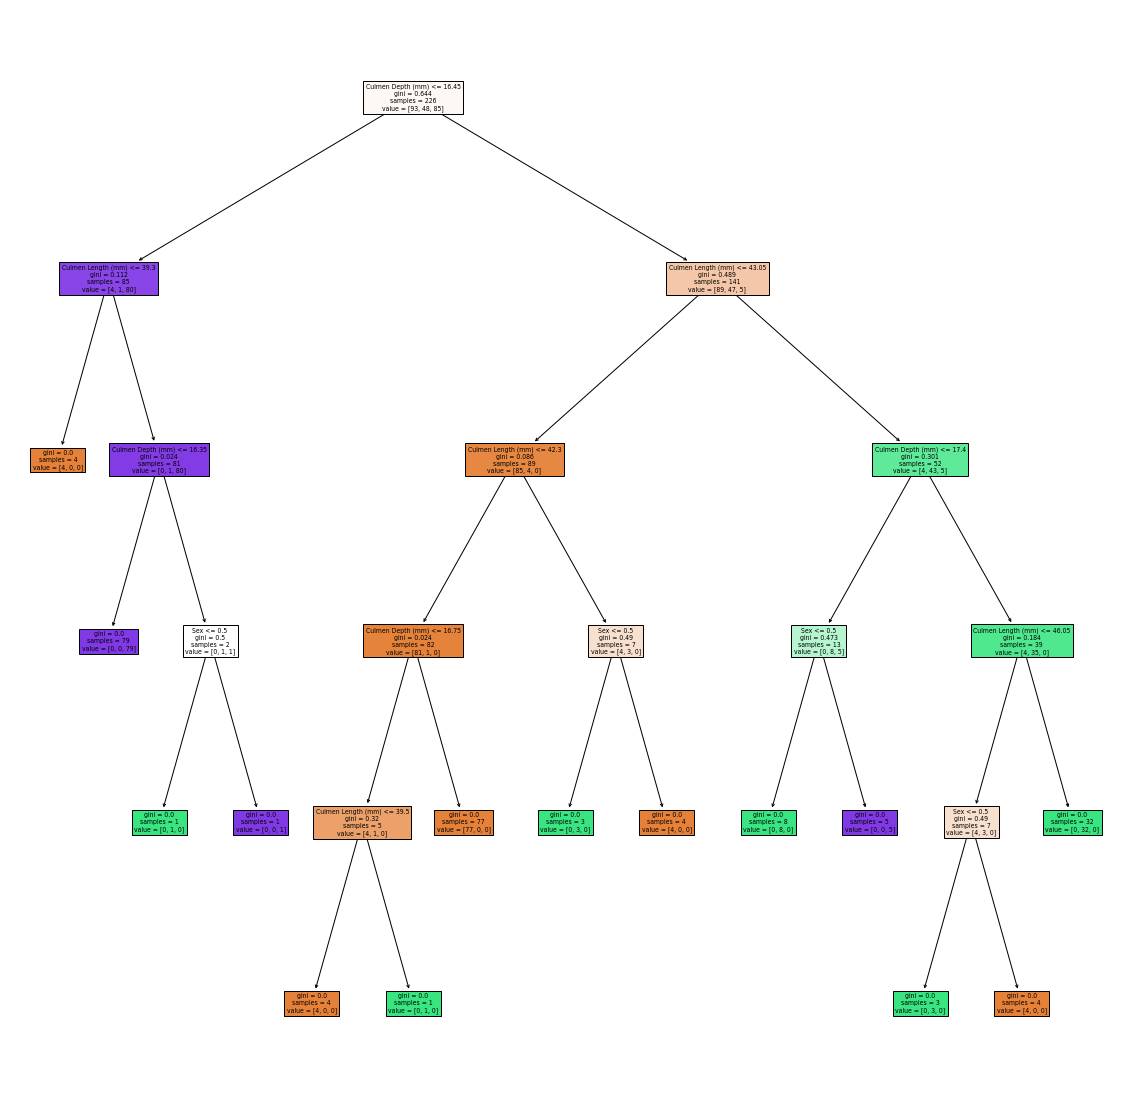

In [45]:
fig, ax = plt.subplots(1, figsize = (20, 20))
p = tree.plot_tree(T, filled = True, feature_names = cols)

# Discussion

#### Model Selection

Though we have been able to determine that our models work perfectly with a large dataset, there are always other ways to optimize our model. For one, trying different models would be interesting to try. Since the data set is smaller, we could have tried different machine learning methods. Instead of just using decision trees and logistic reggression, we could have used other **supervised** machine learning methods, specifically other tree-based models like **random forest models**. Instead of just using one single tree to make a decision and predict between labels (in our case, species), we can leverage the statistical power that our entire "forest" (all our trees) in order to make a more accurate prediction. 

Moreover, since our data is rather small, we could also try using a **gradient boosted tree method**. One advantage of this is that it optimizes (in this case minimizes) our cost funtion. It often is helpful to try with sparse data. This could help for smaller data or smaller sized data with few value counts.

**Another thing we could do is to try very different types of machine learning methods, more specifically *unsupervised machine learning methods* such as PCA (principal component analysis), TCA (tensor component analysis, see Rahmani et al, 2018), k-means clustering, or mixture models.** What this enables us to do is to investigate from afar and avoid too much human intervention. Instead of having labels, we can try reinforcement learning or cluster analyses that allow us not only identify outliers in our clusters, but also to prevent (to a *degree*) human-driven overfitting.

https://www.nature.com/articles/nmeth.3809

#### Censored Data/Imputations

Furthermore, early in the data cleaning process, I had removed around 10 rows/observations from the penguins data set when executing `dropna()` to remove NaN values seen in some of the penguins' column data. This was done to ensure no compile errors during our automated feature selection and ultimately our model construction and backtesting.

Though removing a few rows seems like a miniscule difference, it can potentially be important, as losing observations means that we lose our statistical power, or the probability that we correctly made our prediction/decision (at least in the context of our project; often is used to see a difference in an inference test). Though our model was still able to predict with very high accuracy, we can resolve this through imputations, which is a technique often used in genomics and other high throughput data. Data imputation is a method that allows us to replace missing values based on our current data and can be especially in sparse data. However, as Professor Chodrow has said, there are tradeoffs with censored data and imputation; for one, imputation introduces morebias and uncertainty to our model (whether it was actually a correct label or accurate value imputed). 

In our case, we decided that removing missing values would be the best decision, as our sample size `n` had a marginally smaller magnitude that yielded high results that clearly were not **solely** due to the removal of these observations.